In [1]:
import numpy as np
import cv2
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import os
import sys
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm as svm_sk
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import time

# Preprocessing Training data
fruit_images_t = []
labels_t = []
imagesize = 45
for fruit_dir_path in glob.glob("fruits-360/Training/*"):
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        image = cv2.resize(image, (imagesize, imagesize))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        fruit_images_t.append(image)
        labels_t.append(fruit_label)
fruit_images_t = np.array(fruit_images_t)
labels_t = np.array(labels_t)

# Preprocessing Validation data
fruit_images_v = []
labels_v = []
for fruit_dir_path in glob.glob("fruits-360/Validation/*"):
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        image = cv2.resize(image, (imagesize, imagesize))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        fruit_images_v.append(image)
        labels_v.append(fruit_label)
fruit_images_v = np.array(fruit_images_v)
labels_v = np.array(labels_v)

# Create dicts/arrays for Training Data
names_t = np.unique(labels_t)
ids_t = [k for k in range(0, len(names_t))]
name_id_t = list(zip(names_t, ids_t))
id_to_name_t = {id: name for (name, id) in name_id_t}
name_to_id_t = {name: id for (name, id) in name_id_t}
label_ids_t = np.array([name_to_id_t[x] for x in labels_t])

# Create dicts/arrays for Validation dat
names_v = np.unique(labels_v)
ids_v = [k for k in range(len(names_v))]
id_name_v = list(zip(ids_v, names_v))
name_to_id_v = {name: id for (id, name) in id_name_v}
id_to_name_v = {id: name for (id, name) in id_name_v}
label_ids_v = np.array([name_to_id_v[x] for x in labels_v])

#End of preprocessing stage

C:\Users\Eskil\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


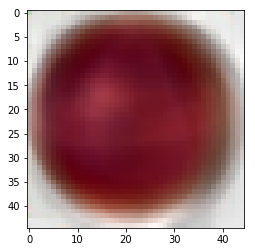

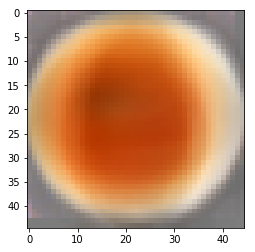

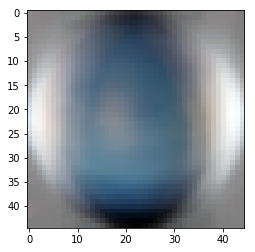

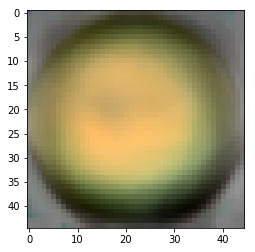

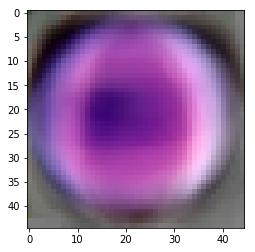

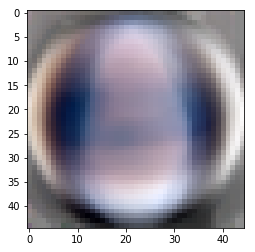

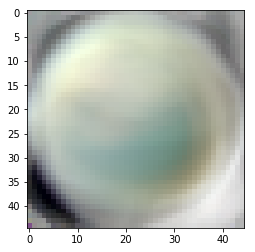

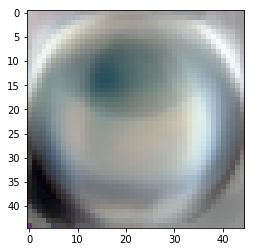

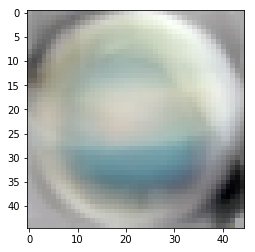

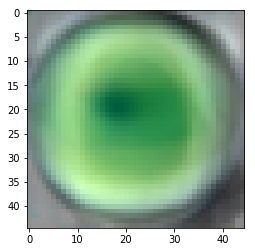

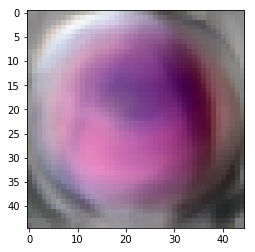

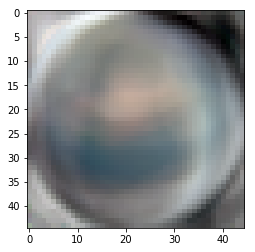

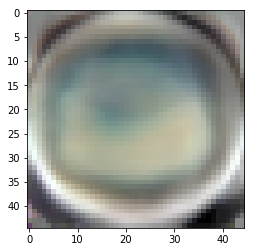

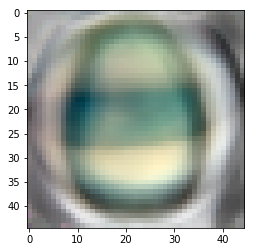

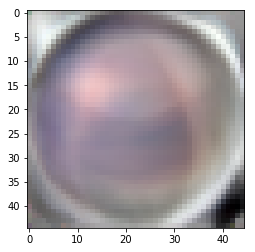

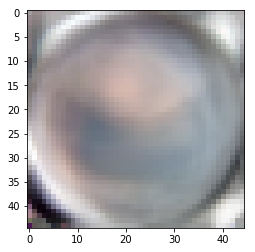

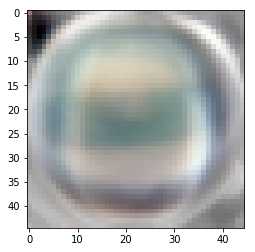

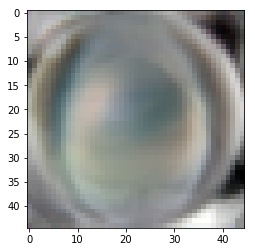

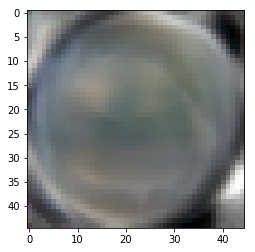

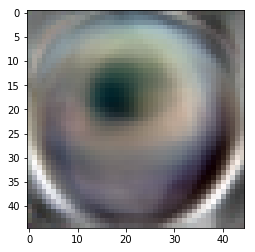

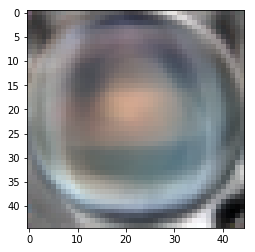

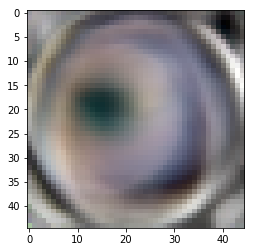

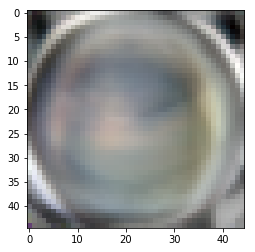

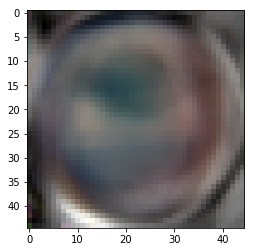

In [10]:
# PCA Cell
# Scale Training data and then run PCA on it
ncomp = 24
scaler = StandardScaler()
scaled_images = scaler.fit_transform([im.flatten() for im in fruit_images_t])
pca = PCA(n_components=ncomp)

pca_result_t = pca.fit_transform(scaled_images)
#print(pca.explained_variance_ratio_)
#print(np.sum(pca.explained_variance_ratio_))
#print(pca_result_t)
#print(pca.components_[0])
for i in range(ncomp):
    maxx = np.max(pca.components_[i])
    minn = np.min(pca.components_[i])
    diver = maxx - minn
    plt.figure()
    im = (pca.components_[i].reshape((imagesize,imagesize,3)) -minn)/diver
    image = np.zeros((imagesize, imagesize, 3))
    image[:,:,0] = im[:,:,2]
    image[:,:,1] = im[:,:,1]
    image[:,:,2] = im[:,:,0]
    plt.imshow(image)
#print(fruit_images_t[0].flatten().shape)
# Split training set
X_train, X_test, y_train, y_test = train_test_split(pca_result_t, label_ids_t, test_size=0)

# Scale Validation Data and run PCA on it
images_scaled = scaler.transform([im.flatten() for im in fruit_images_v])
pca_result_v = pca.transform(images_scaled)

In [62]:
#For saving the components
for i in range(ncomp):
    maxx = np.max(pca.components_[i])
    minn = np.min(pca.components_[i])
    diver = maxx - minn
    image = (pca.components_[i].reshape((imagesize,imagesize,3)) -minn)/diver
    filename = 'component%i.jpg' %i
    #plt.imsave(filename, image) Uncomment to save the files

Accuracy with SVM on X_test: 90.940726


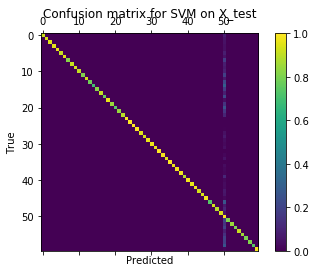

In [8]:
# Train SVM
svm = svm_sk.SVC()
svm = svm.fit(X_train, y_train)

# Make predictions w/ both classifiers
svm_test_predictions = svm.predict(X_test)

# Compute accuracy scores
svm_precision_t = accuracy_score(svm_test_predictions, y_test) * 100
print("Accuracy with SVM on X_test: {0:.6f}".format(svm_precision_t))

# Compute Confusion Matrices for both classifiers
cm_svm_t = confusion_matrix(y_test, svm_test_predictions)
cm_svm_t = normalize(cm_svm_t, axis=1, norm='l1')

# Plot both confusion matrices (separate windows)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_svm_t)
plt.title('Confusion matrix for SVM on X_test')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [9]:
# Predict on with all classifiers Validation data
svm_prediction_v = svm.predict(pca_result_v)

# Compute accuracy scores for all classifiers
svm_precision_v = accuracy_score(svm_prediction_v, label_ids_v) * 100

print("Accuracy with SVM on Validation data: {0:.6f}".format(svm_precision_v))

# Compute confusion matrices for all classifiers
cm_svm_v = confusion_matrix(label_ids_v, svm_prediction_v)
cm_svm_v = normalize(cm_svm_v, axis=1, norm='l1')

Accuracy with SVM on Validation data: 46.376512


In [12]:
# Train Random Forest
forest = RandomForestClassifier(n_estimators=100)
forest = forest.fit(X_train, y_train)
"""
# Make predictions w/ both classifiers
forest_test_predictions = forest.predict(X_test)

# Compute accuracy scores
forest_precision_t = accuracy_score(forest_test_predictions, y_test) * 100 
print("Accuracy with RF on X_test: {0:.6f}".format(forest_precision_t))

# Compute Confusion Matrices for both classifiers
cm_forest_t = confusion_matrix(y_test, forest_test_predictions)
cm_forest_t = normalize(cm_forest_t, axis=1, norm='l1')

# Plot both confusion matrices (separate windows)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_forest_t)
plt.title('Confusion matrix for Random Forest on X_test')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
"""

'\n# Make predictions w/ both classifiers\nforest_test_predictions = forest.predict(X_test)\n\n# Compute accuracy scores\nforest_precision_t = accuracy_score(forest_test_predictions, y_test) * 100 \nprint("Accuracy with RF on X_test: {0:.6f}".format(forest_precision_t))\n\n# Compute Confusion Matrices for both classifiers\ncm_forest_t = confusion_matrix(y_test, forest_test_predictions)\ncm_forest_t = normalize(cm_forest_t, axis=1, norm=\'l1\')\n\n# Plot both confusion matrices (separate windows)\nfig = plt.figure()\nax = fig.add_subplot(111)\ncax = ax.matshow(cm_forest_t)\nplt.title(\'Confusion matrix for Random Forest on X_test\')\nfig.colorbar(cax)\nplt.xlabel(\'Predicted\')\nplt.ylabel(\'True\')\nplt.show()\n'

In [13]:
# Predict on with all classifiers Validation data
forest_prediction_v = forest.predict(pca_result_v)

# Compute accuracy scores for all classifiers
forest_precision_v = accuracy_score(forest_prediction_v, label_ids_v) * 100


print("Accuracy with RF on Validation data: {0:.6f}".format(forest_precision_v))

# Compute confusion matrices for all classifiers
cm_forest_v = confusion_matrix(label_ids_v, forest_prediction_v)
cm_forest_v = normalize(cm_forest_v, axis=1, norm='l1')

Accuracy with RF on Validation data: 91.915641


100
0.91905303421896


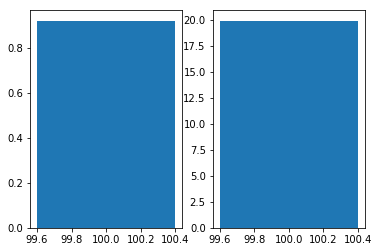

In [23]:
# TEST_AREA____________________________________________________________________________________________
# How the different parameters effects the preformance accuracy wise and time wise
# The more estimators the better result, it takes more time tho
# Max_features doesn't matter that much...
tries = 1
accuracys = []
times = []
begin = 100
nd = begin
for i in range(begin,nd+1):
    print(i)
    avg_acc = 0
    start = time.time()
    for j in range(tries):
        forest = RandomForestClassifier(n_estimators=i, max_features='auto',max_depth=None)
        forest = forest.fit(X_train, y_train)
        forest_prediction_v = forest.predict(pca_result_v)
        forest_precision_v = accuracy_score(forest_prediction_v, label_ids_v)
        avg_acc += forest_precision_v
    daend = time.time()
    times.append(daend-start)
    accuracys.append(avg_acc)
fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
ax1.bar(np.linspace(begin,nd,nd+1-begin), accuracys[:])
ax2 = fig1.add_subplot(122)
ax2.bar(np.linspace(begin,nd,nd+1-begin), times[:])
print(accuracys[-1])

In [ ]:
#Test area, which number of PCA components is the best?
